In [587]:
import os, subprocess, warnings
from datetime import datetime
from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from datetime import datetime
from scipy.integrate import quad, quad_vec, trapz, cumtrapz
from scipy.optimize import fsolve
from scipy.ndimage import gaussian_filter
from scipy.special import erf
from scipy.interpolate import griddata, interpn
from scipy.signal import welch

from sim import *
import const


In [2]:
#sim_eps0p01 = Sim(ALPHA_EPS0P01, "gridded_data_small.npz", epsilon_SF=0.01)
#sim_eps0p1 = Sim(ALPHA_EPS0P1, "gridded_data_small.npz", epsilon_SF=0.1)
#sim_eps1p0 = Sim(ALPHA_EPS1P0, "gridded_data_small.npz", epsilon_SF=1.0)
sim_gas = Sim(GAS, "gridded_data_small.npz", epsilon_SF=None)
#list_of_sim = [sim_eps0p01, sim_eps0p1, sim_eps1p0, sim_gas]


Moving to directory '/home/za9132/scratch/romain/gas'.


In [3]:
sim = sim_gas


### Accretion

In [137]:
def calc_norm(a):
    ''' Compute the norm of a vector. '''
    return np.sqrt(np.sum(a**2, axis=0))

def calc_dot(a, b):
    ''' Compute the dot product of two vectors '''
    return np.sum(a * b, axis=0)

def calc_proj(a, b, do_norm=True):
    ''' Compute the projection of one vector onto another '''
    if do_norm:
        return calc_dot(a, b) / calc_norm(b)
    else:
        return (calc_dot(a, b) / calc_norm(b)**2)[None, :, :, :] * b
    
def symlog(x, C):
    
    return np.sign(x) * np.log10(1 + np.abs(x / C))


In [198]:
h = np.cross(sim.coord, sim.vel_vec, axis=0)
h_tot = sim.calc_mean(ang_mom, weight=(sim.density * sim.dV), axis=(1, 2, 3), do_sum=True)
h_scalar = calc_proj(ang_mom, ang_mom_tot[:, None, None, None])

Ldot = sim.interp_to_sph(h_scalar * sim.density * sim.vel_vec_sph_at_cart[R]) * sim.dA_hph
Ldot_1d = sim.calc_mean(Ldot, axis=(1, 2), do_sum=True)


Text(0, 0, '$z$')

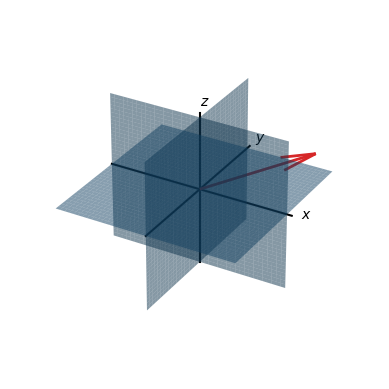

In [215]:
ax = plt.figure().add_subplot(projection='3d')

x, y = np.mgrid[-1:1:0.05, -1:1:0.05]
z = np.zeros_like(x)

ax.plot_surface(x, y, z, color='C0', alpha=0.5)
ax.plot_surface(z, y, x, color='C0', alpha=0.5)
ax.plot_surface(x, z, y, color='C0', alpha=0.5)

ax.quiver(0, 0, 0, h_tot[X], h_tot[Y], h_tot[Z], length=1.2, normalize=True, lw=2, color='C3')

ax.plot([-1, 1], [0, 0], [0, 0], color='black')
ax.plot([0, 0], [-1, 1], [0, 0], color='black')
ax.plot([0, 0], [0, 0], [-1, 1], color='black')

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$z$")

ax.axis("off")

ax.text(1.1, 0, 0, r"$x$")
ax.text(0, 1.1, 0, r"$y$")
ax.text(0, 0, 1.1, r"$z$")


Text(0.5, 1.0, '$L_0$ is the angular momentum of $M_\\odot$ in a circular orbit at $r = 1~{\\rm kpc}$')

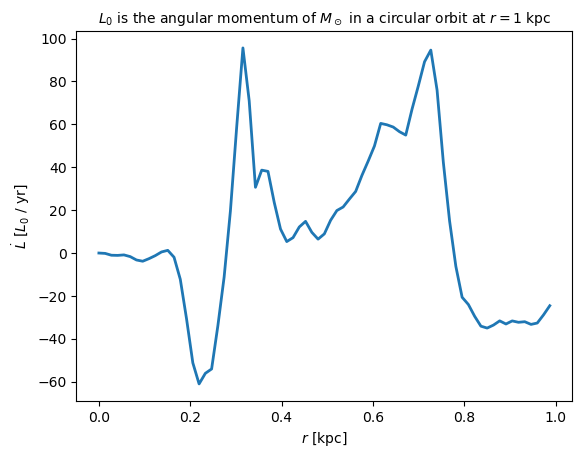

In [250]:
radius = 1 * const.kpc
M_enc = sim.calc_mean(sim.density * sim.dV, cond=(sim.r < radius), do_sum=True)
L0 = const.M_sol * np.sqrt(const.G * M_enc * radius)

plt.plot(sim.coord_r_1d / const.kpc, Ldot_1d / (L0 / const.yr), lw=2)

plt.xlabel(r"$r$ [kpc]")
plt.ylabel(r"$\dot{L}$ [$L_0~/~{\rm yr}$]")

plt.title(r"$L_0$ is the angular momentum of $M_\odot$ in a circular orbit at $r = %.3g~{\rm kpc}$" % (radius / const.kpc), fontsize=10)


In [202]:
Mdot = -sim.interp_to_sph(sim.vel_vec_sph_at_cart[R] * sim.density) * sim.dA_hph
Mdot_1d = sim.calc_mean(Mdot, axis=(1, 2), do_sum=True)
density_sph = sim.interp_to_sph(sim.density)


Text(0, 0.5, '$\\dot{M}$ [${\\rm M_\\odot/yr}$]')

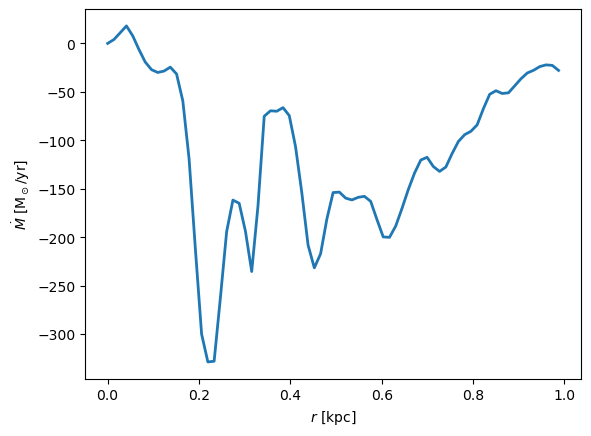

In [203]:
plt.plot(sim.coord_r_1d / const.kpc, Mdot_1d / (const.M_sol / const.yr), lw=2)

plt.xlabel(r"$r$ [kpc]")
plt.ylabel(r"$\dot{M}$ [${\rm M_\odot/yr}$]")


Text(0.5, 1.0, '$r = 1~{\\rm kpc}$')

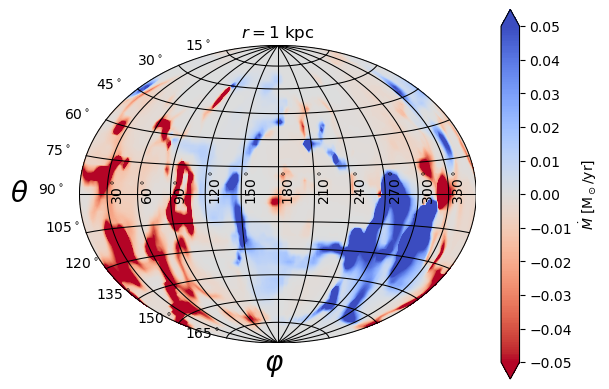

In [11]:
radius = 1. * const.kpc
radius_idx = np.argmin(np.abs(sim.coord_r_1d - radius))

sim.plot_AH(Mdot[radius_idx] / (const.M_sol / const.yr), (-0.05, 0.05), do_log=False, cmap='coolwarm_r', num_axis_lines=12, cbar_tick_increment=0.01, cbar_label=r'$\dot{M}$ [${\rm M_\odot/yr}$]')

plt.title(r"$r = %.3g~{\rm kpc}$" % (radius / const.kpc))


Text(0.5, 1.0, '$r \\in [0.5, 1]~{\\rm kpc}$')

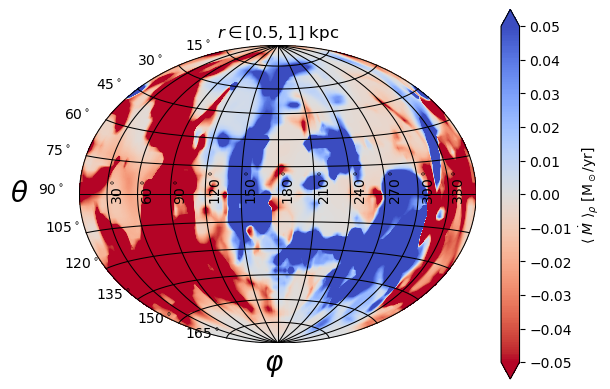

In [12]:
radius_in, radius_out = 0.5 * const.kpc, 1 * const.kpc
cond = (sim.coord_sph[R] < radius_out) * (sim.coord_sph[R] > radius_in)

Mdot_avg = sim.calc_mean(Mdot, weight=(density_sph * sim.dr), cond=cond, axis=R)

sim.plot_AH(Mdot_avg / (const.M_sol / const.yr), (-0.05, 0.05), do_log=False, cmap='coolwarm_r', num_axis_lines=12, cbar_tick_increment=0.01, cbar_label=r'$\langle~\dot{M}~\rangle_\rho$ [${\rm M_\odot/yr}$]')

plt.title(r"$r \in [%.3g, %.3g]~{\rm kpc}$" % (radius_in / const.kpc, radius_out / const.kpc))


### Dust

Text(0.5, 1.0, '$|x| < 1~{\\rm kpc}$')

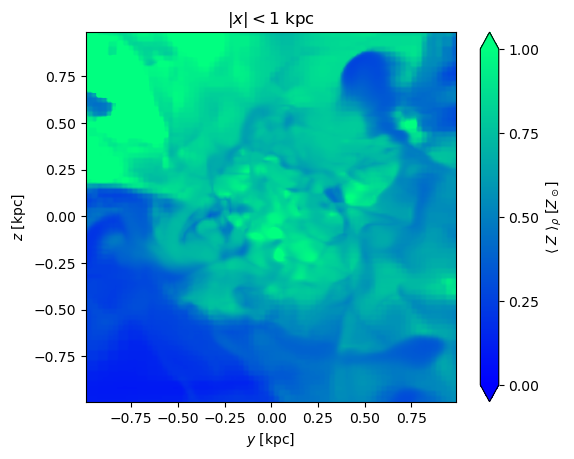

In [9]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.metallicity / const.Z_sol, (0, 1), avg=True, slice=slice, weight=sim.density, project=True, do_log=False, cmap='winter', cbar_label=r'$\langle~Z~\rangle_\rho$ [$Z_\odot$]', cbar_tick_increment=0.25)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

# sim.save_fig("metal-proj-%s" % slice_label)


Text(0.5, 1.0, '$|z| < 1~{\\rm kpc}$')

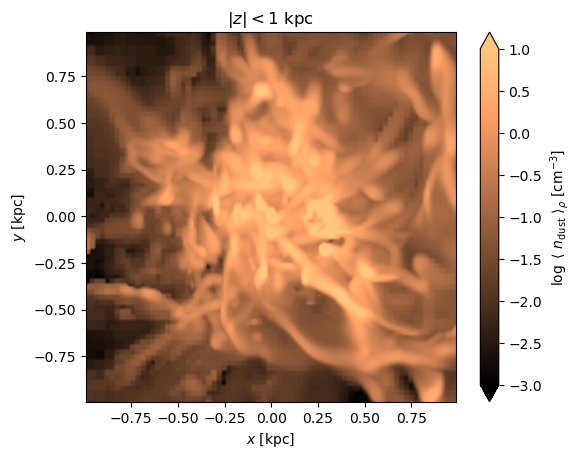

In [14]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.n_dust, (1e-3, 1e1), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='copper', cbar_label=r'$\log~\langle~n_{\rm dust}~\rangle_\rho$ [${\rm cm^{-3}}$]', cbar_tick_increment=0.5)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

# sim.save_fig("SFR-proj-%s" % slice_label)


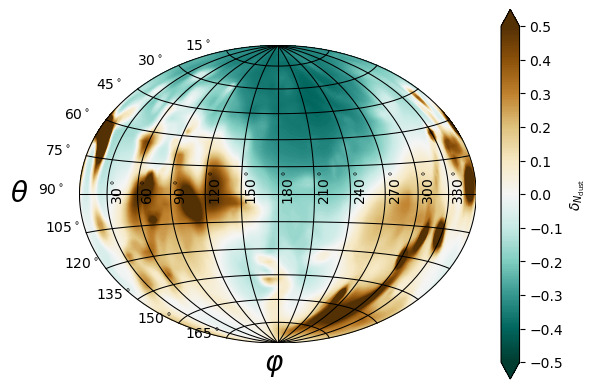

In [13]:
n_dust_sph = sim.interp_to_sph(sim.n_dust)
N_dust = np.sum(n_dust_sph * sim.dr, axis=R)
N_dust_avg = np.sum(N_dust * sim.dA_hph[-1]) / np.sum(sim.dA_hph[-1])
N_dust_delta = (N_dust - N_dust_avg) / N_dust_avg

sim.plot_AH(N_dust_delta, (-0.5, 0.5), do_log=False, cmap='BrBG_r', num_axis_lines=12, cbar_tick_increment=0.1, cbar_label=r'$\delta_{N_{\rm dust}}$')
        

### Multi-freefall Model

Text(0.5, 1.0, '$|z| < 1~{\\rm kpc}$')

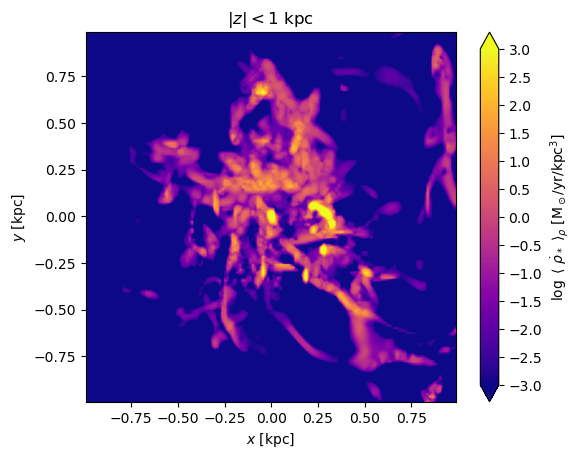

In [31]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.SFR_density / (const.M_sol / const.yr / const.kpc**3), (1e-3, 1e3), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='plasma', cbar_label=r'$\log~\langle~\dot{\rho}_*~\rangle_\rho$ [${\rm M_\odot/yr/kpc^3}$]', cbar_tick_increment=0.5)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

# sim.save_fig("SFR-proj-%s" % slice_label)


### Gas Properties

Text(0.5, 1.0, '$|z| < 1~{\\rm kpc}$')

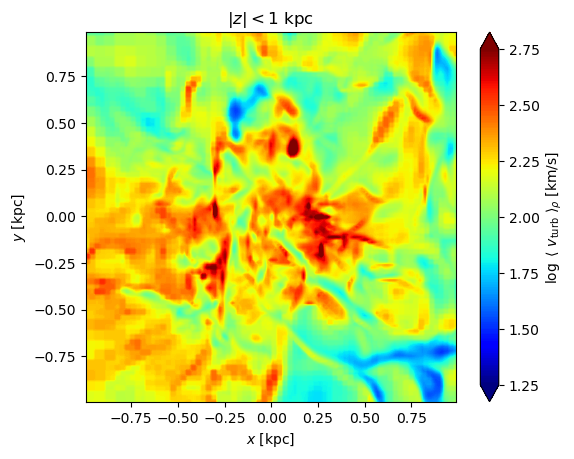

In [19]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.v_turb / (const.km), (10**(1.25), 10**(2.75)), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='jet', cbar_label=r'$\log~\langle~v_{\rm turb}~\rangle_\rho$ [km/s]', cbar_tick_increment=0.25)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

# sim.save_fig("v-proj-%s" % slice_label)


Text(0.5, 1.0, '$|z| < 1~{\\rm kpc}$')

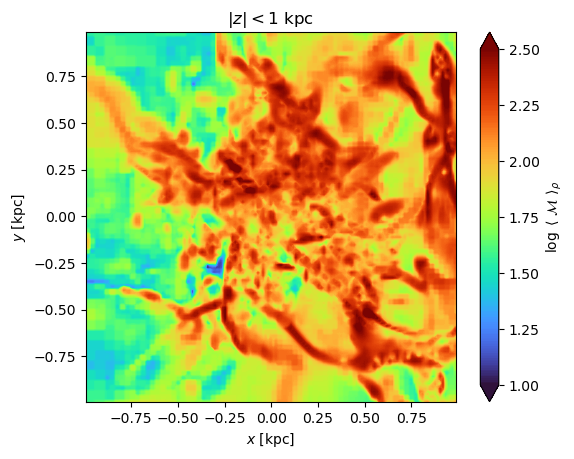

In [21]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.mach, (10**(1.), 10**(2.5)), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='turbo', cbar_label=r'$\log~\langle~\mathcal{M}~\rangle_\rho$', cbar_tick_increment=0.25)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

# sim.save_fig("mach-proj-%s" % slice_label)


Text(0.5, 1.0, '$|z| < 1~{\\rm kpc}$')

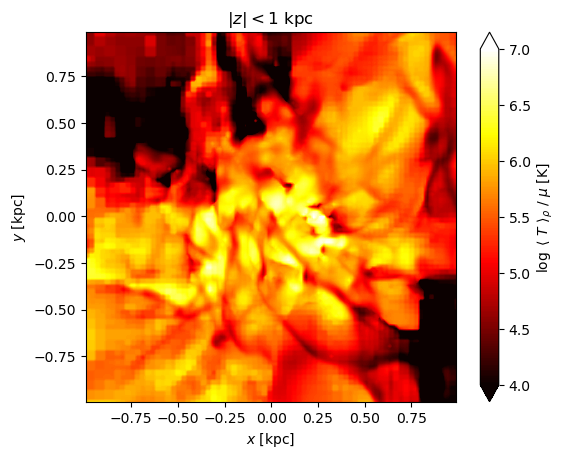

In [15]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.temperature, (1e4, 1e7), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='hot', cbar_label=r'$\log~\langle~T~\rangle_\rho~/~\mu$ [K]', cbar_tick_increment=0.5)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

# sim.save_fig("temp-proj-%s" % slice_label)


Text(0.5, 1.0, '$|y| < 1~{\\rm kpc}$')

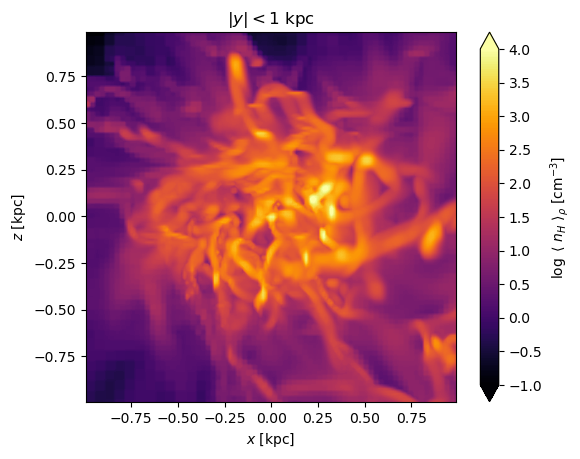

In [55]:
slice = Y
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.n_H, (1e-1, 1e4), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='inferno', cbar_label=r'$\log~\langle~n_H~\rangle_\rho$ [${\rm cm^{-3}}$]', cbar_tick_increment=0.5)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

# sim.save_fig("density-proj-%s" % slice_label)


In [29]:
n_H_2d, temperature_2d, mass_2d = sim.calc_phase(sim.n_H, sim.temperature, (1e-4, 1e5), (1e1, 1e9), nbins=200)


Saved figure as 'density-temp-phase-092720231137.png'


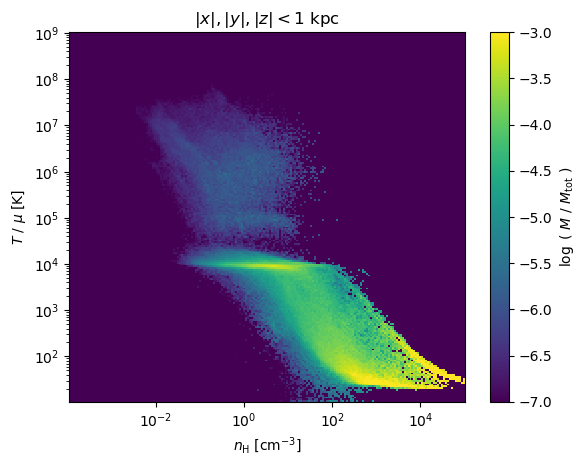

In [134]:
mass_frac_2d = mass_2d / np.sum(sim.density * sim.dV)

plt.pcolor(n_H_2d, temperature_2d, np.log10(mass_frac_2d + epsilon), vmin=-7, vmax=-3)

plt.xlabel(r"$n_{\rm H}$ [${\rm cm^{-3}}$]")
plt.ylabel(r"$T~/~\mu$ [K]")

plt.xscale('log')
plt.yscale('log')

plt.colorbar(label=r'$\log~(~M~/~M_{\rm tot}~)$')

plt.title(r'$|x|, |y|, |z| < 1~{\rm kpc}$')

# sim.save_fig("density-temp-phase")


In [135]:
r_1d, density_1d = sim.calc_radial_profile(sim.density, nbins=100)


Saved figure as 'density-1d-092720231137.png'


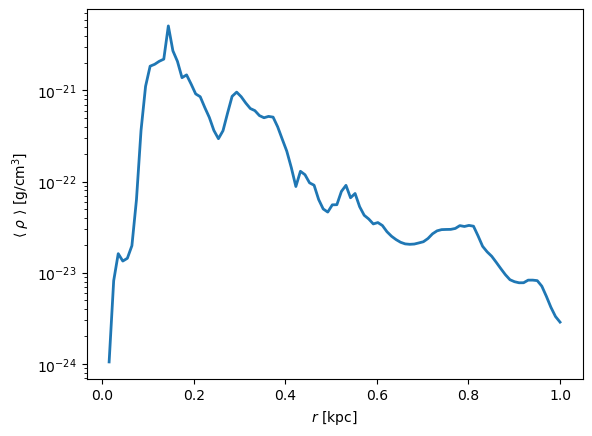

In [136]:
plt.plot(r_1d / const.kpc, density_1d, lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~\rho~\rangle$ [${\rm g/cm^3}$]')

plt.yscale('log')

# sim.save_fig("density-1d")


In [137]:
r_1d, temperature_1d = sim.calc_radial_profile(sim.temperature, weight=sim.density, nbins=100)


Saved figure as 'temp-1d-092720231137.png'


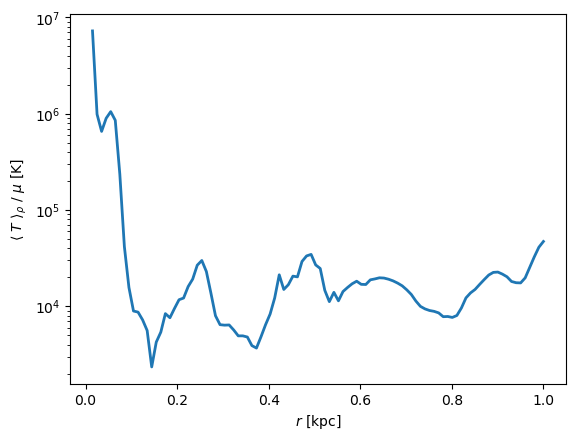

In [138]:
plt.plot(r_1d / const.kpc, temperature_1d, lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~T~\rangle_\rho~/~\mu$ [K]')

plt.yscale('log')

# sim.save_fig("temp-1d")


In [6]:
r_1d, turb_energy_1d = sim.calc_radial_profile(sim.turb_energy, weight=sim.density, nbins=100)
v_turb_1d = np.sqrt(2 * turb_energy_1d)


Text(0, 0.5, '$\\langle~v_{\\rm turb}~\\rangle_\\rho$ [km/s]')

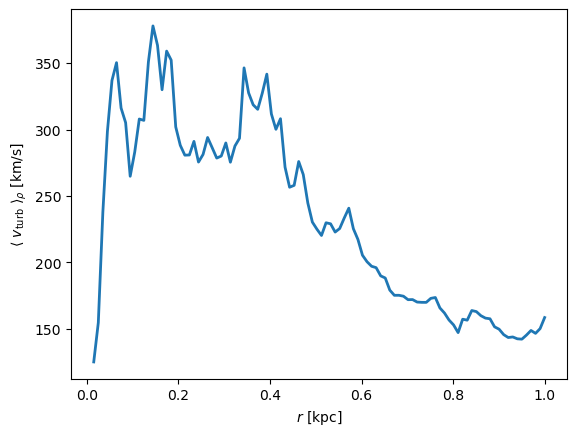

In [7]:
plt.plot(r_1d / const.kpc, v_turb_1d / (const.km), lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~v_{\rm turb}~\rangle_\rho$ [km/s]')

# sim.save_fig("v-turb-1d")


### Refinement

Text(0.5, 1.0, '$z = 0~{\\rm kpc}$')

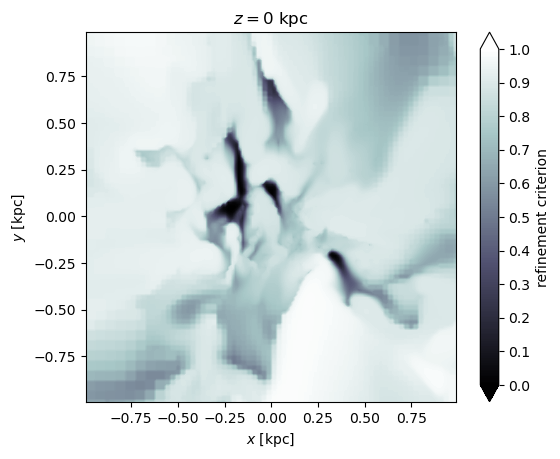

In [28]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.refinement_criterion, (0., 1.), slice=slice, project=False, do_log=False, cmap='bone', cbar_label='refinement criterion', cbar_tick_increment=0.1)

plt.title(r'$%s = 0~{\rm kpc}$' % slice_label)

# sim.save_fig("refine-proj-%s" % slice_label)


### Star Formation Rate

Text(0.5, 1.0, '$|x|, |y|, |z| < 1~{\\rm kpc}$')

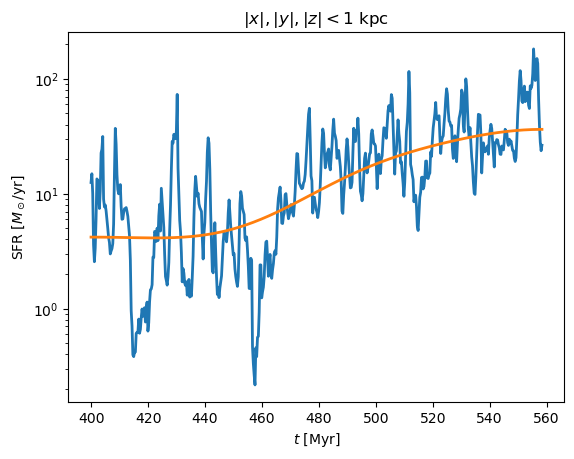

In [892]:
nbins = 1000
filter_sigma = 25 * const.Myr
t_min = 400 * const.Myr

counts, bins = np.histogram(sim.star_birth_time, bins=nbins, weights=sim.star_mass)

star_birth_time = bins[:-1] + np.diff(bins)[0]
t_min_idx = np.argmin(np.abs(star_birth_time - t_min))
star_mass = counts
SFR_mass = star_mass / np.diff(bins)[0]

filter_sigma_idx = filter_sigma / np.diff(star_birth_time)[0]
SFR_mass_smoothed = 10**gaussian_filter(np.log10(SFR_mass[t_min_idx:] + epsilon), sigma=filter_sigma_idx)
#SFR_mass_smoothed = gaussian_filter(SFR_mass[t_min_idx:], sigma=filter_sigma_idx)

plt.plot(star_birth_time[t_min_idx:] / const.Myr, SFR_mass[t_min_idx:] / const.M_sol * const.yr, lw=2, color='C0')
plt.plot(star_birth_time[t_min_idx:] / const.Myr, SFR_mass_smoothed / const.M_sol * const.yr, lw=2, color='C1')

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")

plt.yscale('log')

#plt.ylim(-5, 70)
#plt.xlim(sim.current_time / const.Myr - 100, sim.current_time / const.Myr)

plt.title(r'$|x|, |y|, |z| < 1~{\rm kpc}$')


Text(0.5, 0, '$t$ [Myr]')

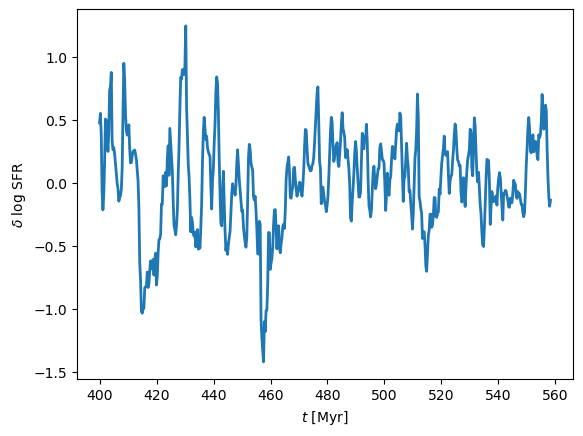

In [893]:
log_SFR_res = np.log10(SFR_mass[t_min_idx:]) - np.log10(SFR_mass_smoothed)

plt.plot(star_birth_time[t_min_idx:] / const.Myr, log_SFR_res, lw=2)

plt.ylabel(r"$\delta$ log SFR")
plt.xlabel(r"$t$ [Myr]")


Text(0, 0.5, 'PSD [${\\rm Myr}$]')

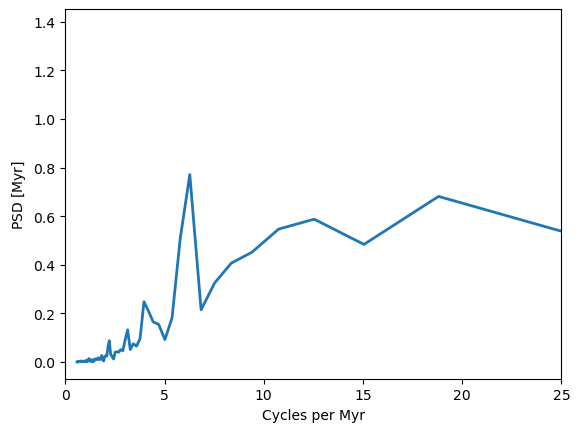

In [898]:
star_birth_time_freqs, SFR_mass_PSD = welch(log_SFR_res, fs=1/np.diff(star_birth_time)[0], detrend=None)

plt.plot(1/(star_birth_time_freqs[1:] * const.Myr), SFR_mass_PSD[1:] / (const.Myr), lw=2)

plt.xlim(0, 25)
#plt.yscale('log')

plt.xlabel("Cycles per Myr")
plt.ylabel(r"PSD [${\rm Myr}$]")


### Summary Statistics

In [30]:
stats = {
    'fields': [sim.density, sim.temperature, sim.metallicity / const.Z_sol, sim.v_turb / const.km, sim.mach, sim.star_age / const.Myr],
    'names': ["density", "temperature", "metallicity", "turbulent velocity", "mach number", "star age"],
    'units': ["g/cm^3", "K", "Z_sol", "km/s", "", "Myr"],
    'weights': [None, sim.density, sim.density, sim.density, sim.density, sim.star_mass],
    'types': [HYDRO, HYDRO, HYDRO, HYDRO, HYDRO, STAR]
}

sim.calc_summary_stats(**stats, do_print=True)



Field                            Max        Min           Mean  Unit
-----------------------  -----------  ---------  -------------  ------
density                     5e-20      1.06e-28       1.79e-23  g/cm^3
temperature                 4.61e+08  10.1       424000         K
metallicity                 8.19       0.0649         0.649     Z_sol
turbulent velocity       2900         16.4          166         km/s
mach number              1270          0.0151       149
star age                  294          0.00132       55.1       Myr
star part number            0          0         864000
dark matter part number     0          0         279000
contamination frac          0          0              0


### Simulation Comparison

Saved figure as 'density-compare-092720231131.png'


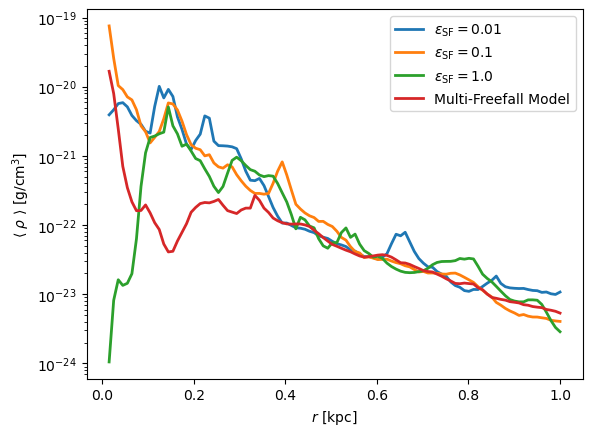

In [54]:
for sim in list_of_sim:
    
    r_1d, density_1d = sim.calc_radial_profile(sim.density, nbins=100)

    plt.plot(r_1d / const.kpc, density_1d, lw=2, label=sim.sim_latex)
    
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~\rho~\rangle$ [${\rm g/cm^3}$]')

plt.legend()

plt.yscale('log')

# save_fig('density-compare')


Saved figure as 'v-turb-compare-092720231130.png'


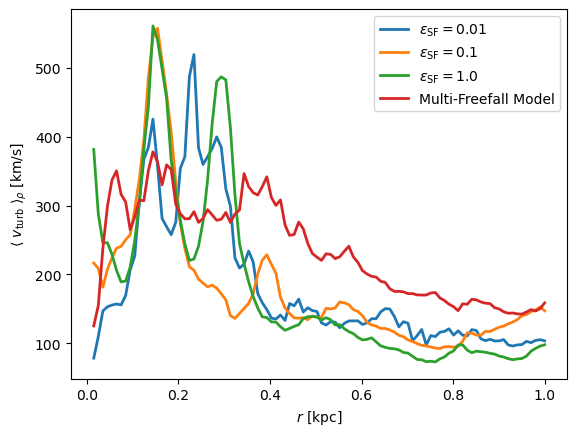

In [53]:
for sim in list_of_sim:
    
    r_1d, turb_energy_1d = sim.calc_radial_profile(sim.turb_energy, weight=sim.density, nbins=100)
    v_turb_1d = np.sqrt(2 * turb_energy_1d)

    plt.plot(r_1d / const.kpc, v_turb_1d / (const.km), lw=2, label=sim.sim_latex)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~v_{\rm turb}~\rangle_\rho$ [km/s]')

plt.legend()

# save_fig('v-turb-compare')


Saved figure as 'temp-compare-092720231130.png'


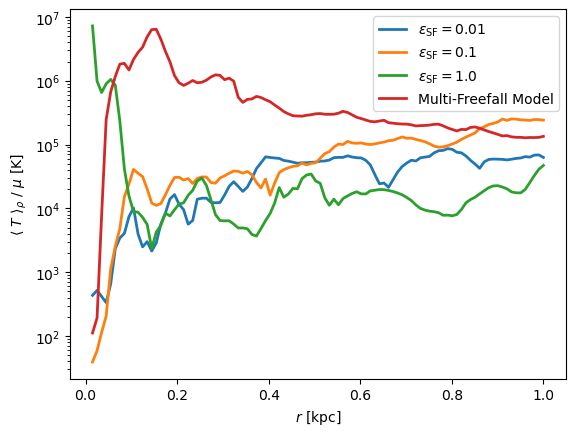

In [52]:
for sim in list_of_sim:
    
    r_1d, temperature_1d = sim.calc_radial_profile(sim.temperature, weight=sim.density, nbins=100)

    plt.plot(r_1d / const.kpc, temperature_1d, lw=2, label=sim.sim_latex)
    
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~T~\rangle_\rho~/~\mu$ [K]')

plt.legend()

plt.yscale('log')

# save_fig('temp-compare')


Text(0.5, 1.0, '$|x|, |y|, |z| < 1~{\\rm kpc}$, $\\sigma = 10~{\\rm Myr}$')

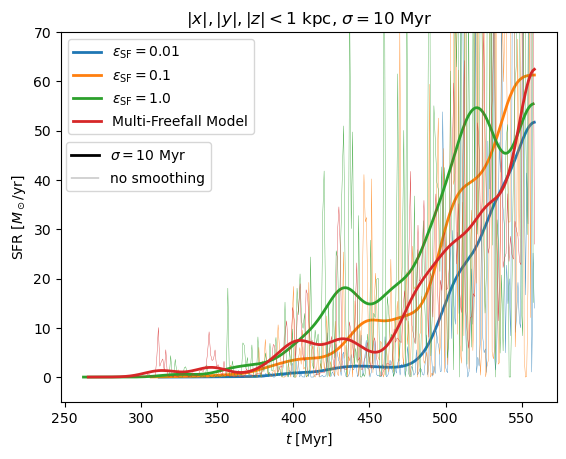

In [26]:
nbins = 300
filter_sigma = 10 * const.Myr

for i, sim in enumerate(list_of_sim):

    counts, bins = np.histogram(sim.star_birth_time, bins=nbins, weights=sim.star_mass)

    star_birth_time_1d = bins[:-1] + np.diff(bins)[0]
    star_mass_1d = counts
    SFR_mass_1d = star_mass_1d / np.diff(bins)[0]

    filter_sigma_idx = filter_sigma / np.diff(star_birth_time_1d)[0]
    SFR_mass_1d_smoothed = gaussian_filter(SFR_mass_1d, sigma=filter_sigma_idx)
    
    plt.plot(star_birth_time_1d / const.Myr, SFR_mass_1d / const.M_sol * const.yr, lw=0.25, alpha=1., color='C%d' % i)
    plt.plot(star_birth_time_1d / const.Myr, SFR_mass_1d_smoothed / const.M_sol * const.yr, lw=2, label=sim.sim_latex, color='C%d' % i)

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")

legend1 = plt.legend()
custom_lines = [Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=0.25)]
legend2 = plt.legend(custom_lines, [r'$\sigma=10~{\rm Myr}$', 'no smoothing'], loc=[0.01, 0.57])
plt.gca().add_artist(legend1)

plt.ylim(-5, 70)

plt.title(r'$|x|, |y|, |z| < 1~{\rm kpc}$, $\sigma = 10~{\rm Myr}$')

# save_fig('SFR-compare')
